Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL Challenge2

# Summary

In this notebook is shown how we analyzed the original dataset provided for this challenge with the objective of obtaining some relevant information about the available data.

Furthermore, in this notebook is possible to see how we manipulated the original time series to obtain detrended time series (without trend) and, also, stationary time series (without trend and without periodicity).


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
import matplotlib.pyplot as plt

import random
random.seed(seed)

from statsmodels.tsa.stattools import acf

### Considerations done on the original dataset

Resources Paths

In [ ]:
categories_file = "./training_dataset/original_datasets/categories.npy"
training_data_file = "./training_dataset/original_datasets/training_data.npy"
valid_periods_file = "./training_dataset/original_datasets/valid_periods.npy"

Loading the dataset

In [ ]:
print("Categories:\n")
categories = np.load(categories_file)
print(categories[0:10])
print(f"Num elem in categories {len(categories)}")

print("\nTraining data:\n")
training_data = np.load(training_data_file)
print(training_data[0:10])
print(f"Num elem: {len(training_data)}")

print("\nValid periods:\n")
valid_periods = np.load(valid_periods_file)
print(valid_periods[0:10])
print(f"Num elem: {len(valid_periods)}")

Categories:

['D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D']
Num elem in categories 48000

Training data:

[[0.         0.         0.         ... 0.60277778 0.36759259 0.33148148]
 [0.         0.         0.         ... 0.6        0.46       0.396     ]
 [0.         0.         0.         ... 0.96048126 0.94650625 0.97714021]
 ...
 [0.         0.         0.         ... 0.8625     0.87625    0.895     ]
 [0.         0.         0.         ... 0.12483039 0.13297151 0.10447761]
 [0.         0.         0.         ... 0.09802158 0.09172662 0.09532374]]
Num elem: 48000

Valid periods:

[[2325 2776]
 [2325 2776]
 [2325 2776]
 [2712 2776]
 [2682 2776]
 [2128 2776]
 [2682 2776]
 [2682 2776]
 [1972 2776]
 [2428 2776]]
Num elem: 48000


Collecting general information about the dataset

In [ ]:
series_per_category = dict()                                                    # We divide series per category
info_per_category = dict()                                                      # We collect general informaion about each category

# We collect general information globally
global_info = {"avg_len_series": 0, "min_len_series": 999999, "max_len_series": 0, "min_value_in_series": 999999, "max_value_in_series": 0, "num_of_series": 0, "tot_len_series": 0}

for i in range(0, len(categories)):
  category = categories[i]

  if category not in series_per_category:
    series_per_category[category] = []
    info_per_category[category] = {"avg_len_series": 0, "min_len_series": 999999, "max_len_series": 0, "min_value_in_series": 999999, "max_value_in_series": 0, "num_of_series": 0, "tot_len_series": 0}

  # We isolate the valid part of each padded time series
  elem = training_data[i, valid_periods[i, 0] : valid_periods[i, 1]]
  if len(elem) != valid_periods[i, 1] - valid_periods[i, 0]:
    raise Exception(f"Invalid series. Index: {i}")

  series_per_category[category].append(elem)
  info_per_category[category]["num_of_series"] += 1
  info_per_category[category]["tot_len_series"] += len(elem)
  global_info["num_of_series"] += 1
  global_info["tot_len_series"] += len(elem)

  if info_per_category[category]["min_len_series"] > len(elem):
    info_per_category[category]["min_len_series"] = len(elem)

  if global_info["min_len_series"] > len(elem):
    global_info["min_len_series"] = len(elem)

  if info_per_category[category]["max_len_series"] < len(elem):
    info_per_category[category]["max_len_series"] = len(elem)

  if global_info["max_len_series"] < len(elem):
    global_info["max_len_series"] = len(elem)

  if info_per_category[category]["min_value_in_series"] > min(elem):
    info_per_category[category]["min_value_in_series"] = min(elem)

  if global_info["min_value_in_series"] > min(elem):
    global_info["min_value_in_series"] = min(elem)

  if info_per_category[category]["max_value_in_series"] < max(elem):
    info_per_category[category]["max_value_in_series"] = max(elem)

  if global_info["max_value_in_series"] < max(elem):
    global_info["max_value_in_series"] = max(elem)

for category in sorted(list(info_per_category.keys())):
  info_per_category[category]["avg_len_series"] = int(info_per_category[category]["tot_len_series"] / info_per_category[category]["num_of_series"])
  print(f"Category: {category}")
  print(f'Num series: {info_per_category[category]["num_of_series"]} Min length: {info_per_category[category]["min_len_series"]} Max length: {info_per_category[category]["max_len_series"]} Avg length: {info_per_category[category]["avg_len_series"]} Max value in series: {info_per_category[category]["max_value_in_series"]} Min value in series: {info_per_category[category]["min_value_in_series"]}')

print("Globally:")
global_info["avg_len_series"] = int(global_info["tot_len_series"] / global_info["num_of_series"])
print(f'Num series: {global_info["num_of_series"]} Min length: {global_info["min_len_series"]} Max length: {global_info["max_len_series"]} Avg length: {global_info["avg_len_series"]} Max value in series: {global_info["max_value_in_series"]} Min value in series: {global_info["min_value_in_series"]}')


Category: A
Num series: 5728 Min length: 46 Max length: 1943 Avg length: 278 Max value in series: 1.0 Min value in series: 0.0
Category: B
Num series: 10987 Min length: 42 Max length: 1484 Avg length: 165 Max value in series: 1.0 Min value in series: 0.0
Category: C
Num series: 10017 Min length: 42 Max length: 2708 Avg length: 208 Max value in series: 1.0 Min value in series: 0.0
Category: D
Num series: 10016 Min length: 42 Max length: 2641 Avg length: 216 Max value in series: 1.0 Min value in series: 0.0
Category: E
Num series: 10975 Min length: 42 Max length: 2776 Avg length: 163 Max value in series: 1.0 Min value in series: 0.0
Category: F
Num series: 277 Min length: 24 Max length: 1068 Avg length: 194 Max value in series: 1.0 Min value in series: 0.0
Globally:
Num series: 48000 Min length: 24 Max length: 2776 Avg length: 198 Max value in series: 1.0 Min value in series: 0.0


Plotting random samples from each category

In [ ]:
#Plotting some time series for each category
def inspect_dataframe_per_category(data, labels, num):
    '''
    Plots a number 'num' of series for each category.
    'Data' is a dict containing the various series divided per category.
    'Labels' is a list containing the various categories names in a ordered way.
    'Labels' is also used as key to access the data dict.
    'Num' is the number of series plotted per category.
    '''

    figs, axs = plt.subplots(len(labels), 1, sharex=True, figsize=(17,17))
    for category_ind, data_key in enumerate(labels):
      for j in range(num):
        idx = np.random.randint(0, len(data[data_key]))
        axs[category_ind].plot(data[data_key][idx])
      axs[category_ind].set_title(data_key)
    plt.show()

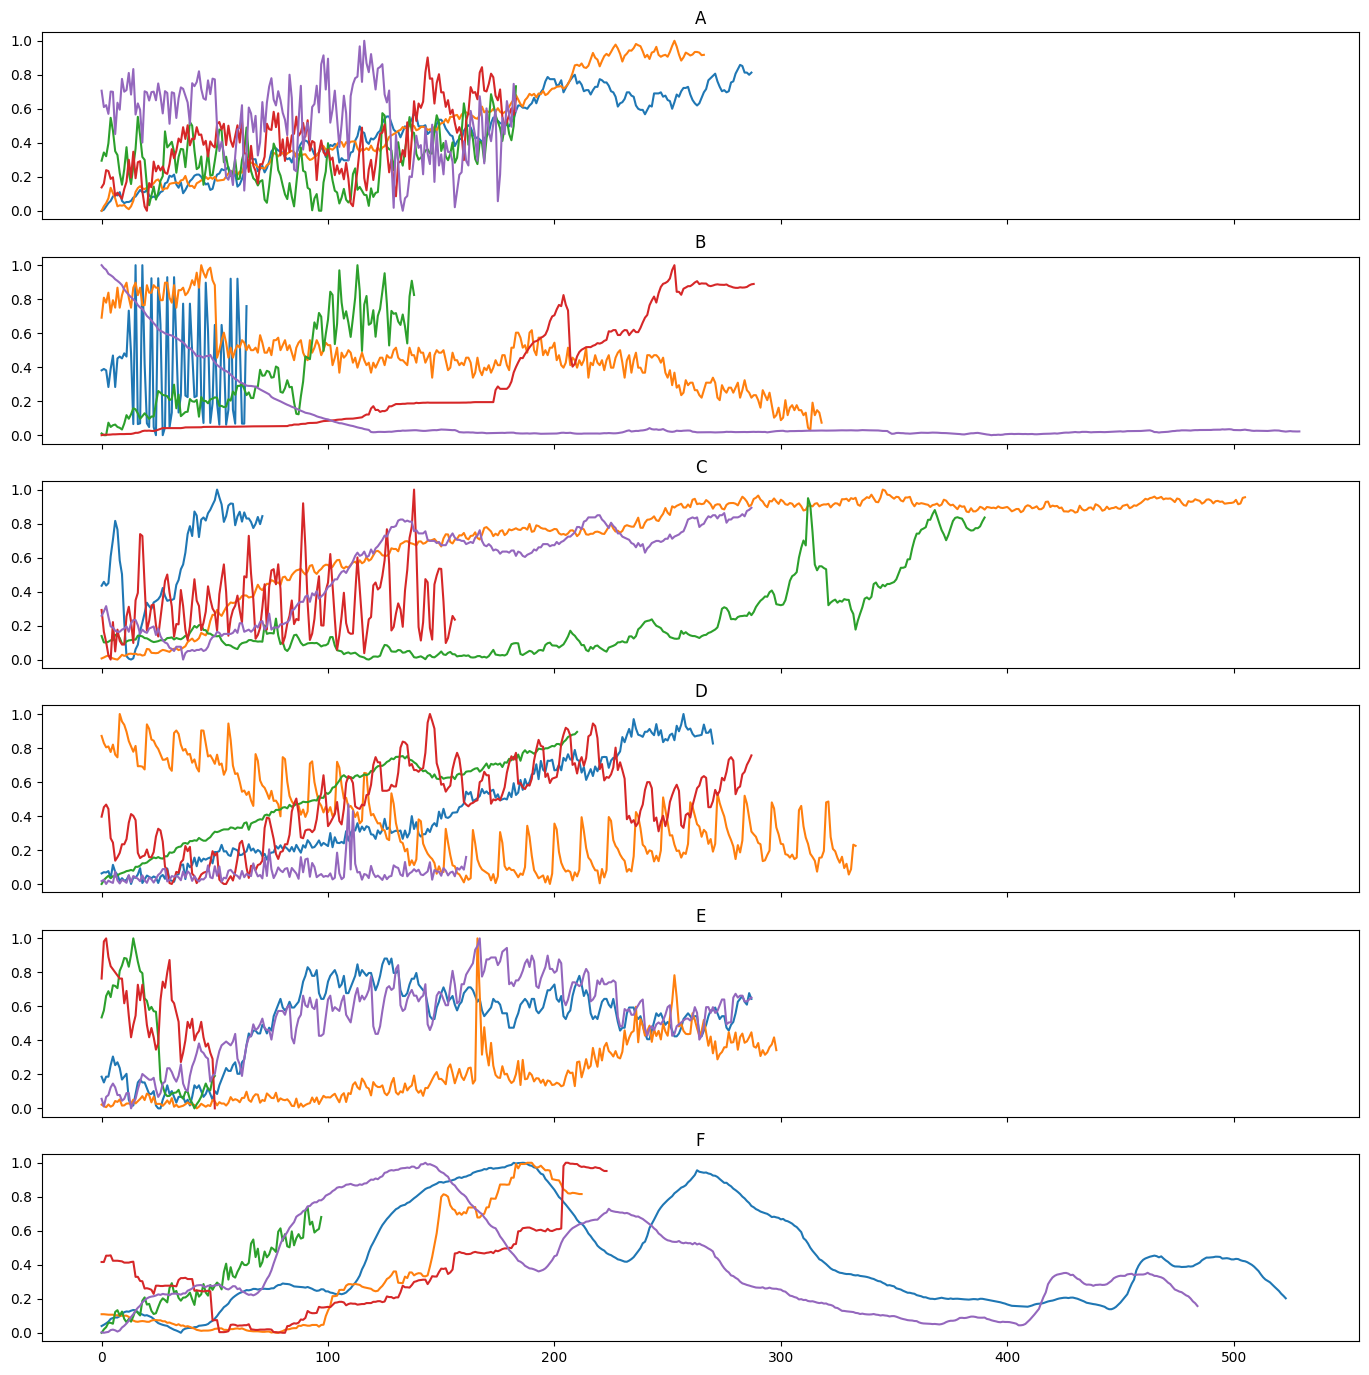

In [ ]:
inspect_dataframe_per_category(series_per_category, ['A', 'B', 'C', 'D', 'E', 'F'], 5)

Split data in train, validation and, possibly, test set (90% for training, 10% for validation and 0% for testing)

In [ ]:
def split_datasets(dataset, percent_of_train = 0.9, percent_of_valid = 0.1, consider_test_set = False):
  '''
  Split the dataset in training, validation and test set.
  'Percent_of_train' is the percentage of dataset used for the training set.
  'Percent_of_valid' is the percentage of dataset used for the validation set.
  'Consider_test_set' is a flag saying if the remaining samples of the dataset should be used for the test set.
  '''

  if percent_of_train + percent_of_valid > 1 or percent_of_train + percent_of_valid <= 0:
    raise Exception("Invalid percentages")

  # If we need a test set, we should have a remaining portion of the dataset to use for it
  if consider_test_set == True:
    if percent_of_train + percent_of_valid == 1:
      raise Exception("No test set is possible")

  # If we don't need a test set, we don't should have any remaining portion of the dataset
  else:
    if percent_of_train + percent_of_valid < 1:
      raise Exception("Impossible division")

  index_train = int(len(dataset)*percent_of_train)
  index_val = int(len(dataset)*(percent_of_valid + percent_of_train))

  train_data = dataset[0: index_train]
  val_data = dataset[index_train: index_val]

  # If we need a test set, we should have a remaining portion of the dataset to use for it
  if consider_test_set:
    test_data = dataset[index_val:]
    return train_data, val_data, test_data
  else:
    return train_data, val_data, []

In [ ]:
# We split the time series of each category in a training part and a validation part

train_data_splitted_in_category = []
val_data_splitted_in_category = []
test_data_splitted_in_category = []

train_data = []
val_data = []
test_data = []

save_npy_files = False                          # Flag that says if the training, the validation and, possibly, the test set should be saved on file
save_only_unified_set = False                   # Flag that says if the training, the validation and, possibly, the test set should be saved on file divided in categories or unified in a single list
train_splitted_in_category_file_path = "./tmp/trainDataSplittedInCategories.npy"
validation_splitted_in_category_file_path = "./tmp/validationDataSplittedInCategories.npy"
test_splitted_in_category_file_path = "./tmp/testDataSplittedInCategories.npy"
train_unified_file_path = "./tmp/trainDataWithoutCategories.npy"
validation_unified_file_path = "./tmp/validationDataWithoutCategories.npy"
test_unified_file_path = "./tmp/testDataWithoutCategories.npy"

use_test = False                                # Flag that says if the test set is needed

for category_label in series_per_category:
  tr, vl, ts = split_datasets(series_per_category[category_label], 0.9, 0.1, use_test)
  train_data_splitted_in_category.append(tr)
  val_data_splitted_in_category.append(vl)
  test_data_splitted_in_category.append(ts)

  train_data += tr
  val_data += vl
  test_data += ts

train_data_splitted_in_category = np.array(train_data_splitted_in_category)
val_data_splitted_in_category = np.array(val_data_splitted_in_category)
test_data_splitted_in_category = np.array(test_data_splitted_in_category)
train_data = np.array(train_data)
val_data = np.array(val_data)
test_data = np.array(test_data)


if save_npy_files:
  np.save(train_unified_file_path, np.array(train_data))
  np.save(validation_unified_file_path, np.array(val_data))

  if use_test:
    np.save(test_unified_file_path, np.array(test_data))

  if save_only_unified_set == False:
    np.save(train_splitted_in_category_file_path,np.array(train_data_splitted_in_category))
    np.save(validation_splitted_in_category_file_path,np.array(val_data_splitted_in_category))

    if use_test:
      np.save(test_splitted_in_category_file_path,np.array(test_data_splitted_in_category))


print("Shapes:")
print(f"Train set splitted in categories: {train_data_splitted_in_category.shape}")
print(f"Validation set splitted in categories: {val_data_splitted_in_category.shape}")
print(f"Test set splitted in categories: {test_data_splitted_in_category.shape}")
print(f"Train set: {train_data.shape}")
print(f"Validation set: {val_data.shape}")
print(f"Test set: {test_data.shape}")


Shapes:
Train set splitted in categories: (6,)
Validation set splitted in categories: (6,)
Test set splitted in categories: (6, 0)
Train set: (43198,)
Validation set: (4802,)
Test set: (0,)


In [ ]:
del valid_periods, training_data, categories, info_per_category
del train_data_splitted_in_category, val_data_splitted_in_category, test_data_splitted_in_category
del train_data, val_data, test_data

### Considerations done on stationary series

Variables initialization

In [ ]:
detrended_series = list()                                                   # List containing the detrended series
rolling_mean_series = list()                                                # List containing the rolling mean series of our series
original_series = list()                                                    # List containing the original series
seasonality_index_of_series = list()                                        # List containing the periodicity for each series
all_stationary_series = list()                                              # List containing the stationary series

# We need to join the series of all the categories inside a single list
for category_label in sorted(list(series_per_category.keys())):
    for series in series_per_category[category_label]:
        original_series.append(series)

random.shuffle(original_series)                                             # We shuffle the list to achieve a random order

Computing the rolling mean series and the detrended series

In [ ]:
window_rolling_mean = 5
stride_rolling_mean = 1

# Compute the rolling mean series and, then, use it to compute the detrended series for each original series
for series in original_series:
    rolling_mean = []

    for i in range(0, len(series) - window_rolling_mean + 1, stride_rolling_mean):
        rolling_mean.append(np.mean(np.array(series[i : i + window_rolling_mean])))     # Compute the average value of the following 'window_rolling_mean' (number) of elements

    while len(rolling_mean) < len(series):
        rolling_mean = np.concatenate((np.array([series[0]]), rolling_mean))            # We pad the rolling mean series using the first value of the original series until it has the same length of the original series

    rolling_mean_series.append(rolling_mean)
    detrended_series.append(series - rolling_mean)                                      # Compute the detrended series

In [ ]:
#Plotting some time series
def inspect_dataframe(data, num):
    '''
    Plots a number 'num' of series.
    'Data' is a list containing the various series.
    'Num' is the number of series plotted.
    '''

    figs, axs = plt.subplots(num, 1, sharex=True, figsize=(17,17))
    for j in range(num):
        idx = np.random.randint(0, len(data))
        axs[j].plot(data[idx])

    plt.show()

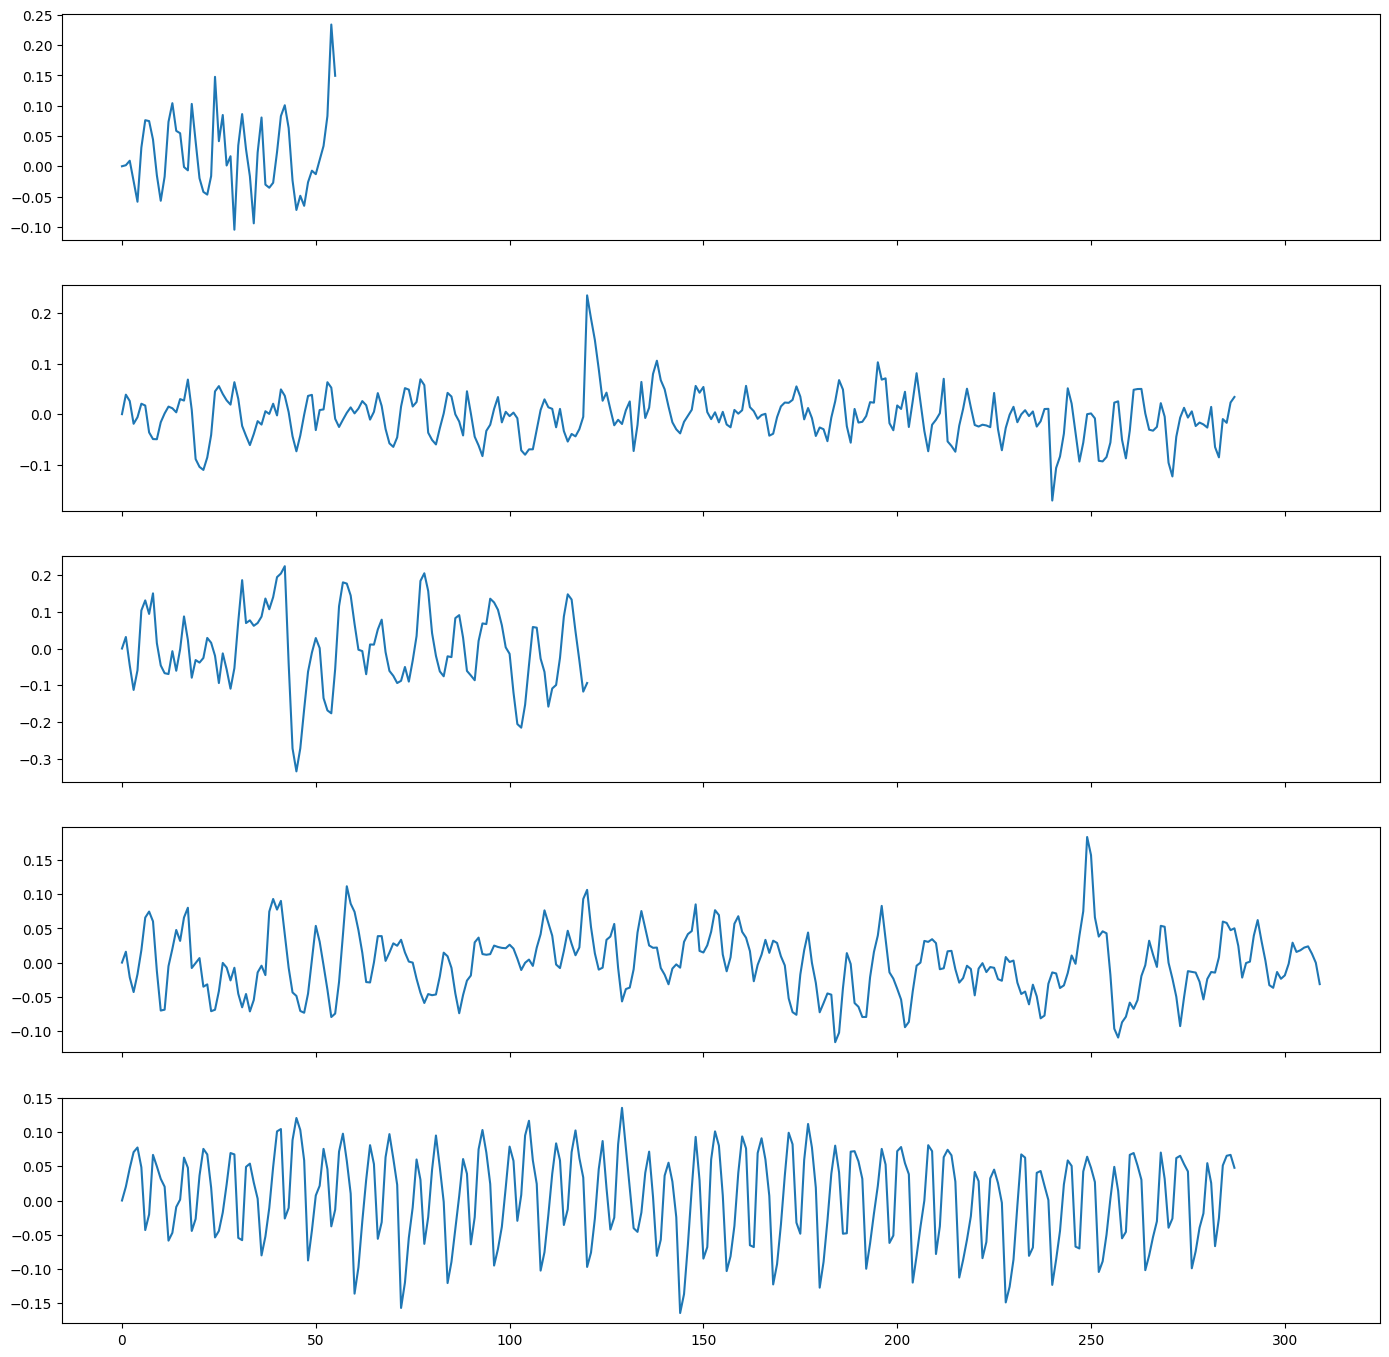

In [ ]:
# Plot some detrended series
inspect_dataframe(detrended_series, 5)

Use the autocorrelation function on the results achieved until this moment

In [ ]:
# We will use this function only in the model.py file of our submissions on Codalab

def manual_acf(x,lags):
    '''
    Custom function that compute the acf of a series 'x' for a number of lags equal to 'lags'.
    We wrote this function because we cannot use the acf function of library 'stattools' on Codalab when submitting our models.
    '''
    lags = range(lags)
    mean=x.mean()
    var=np.var(x)
    xp=x-mean
    corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]

In [ ]:
#Plotting the mean autocorrelation function

def plot_mean_acf(data, lag, title):
    '''
    Plots the mean autocorrelation function.
    'Data' is a list containing the various series to use.
    'Lag' is the number of lag to consider.
    'Title is the title of the plot.
    '''
    acf_list = []

    for series in data:

        # If the series has the length equal or shorter than the number of lag to used, we skip it
        if len(series) <= lag:
            continue

        acf_list.append(acf(series, nlags=lag, fft=True))

    mean_acf = np.mean(acf_list, axis=0)                                        # Computing the mean autocorrelation function
    # Plot the mean ACF
    plt.figure(figsize=(10, 5))
    plt.plot(mean_acf, marker='o', linestyle='--')
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Mean Autocorrelation')
    plt.axhline(y=0, linestyle='-', color='black')  # Zero line
    plt.axhline(y=0.2, linestyle='--', color='red')  # Example significance threshold
    plt.show()

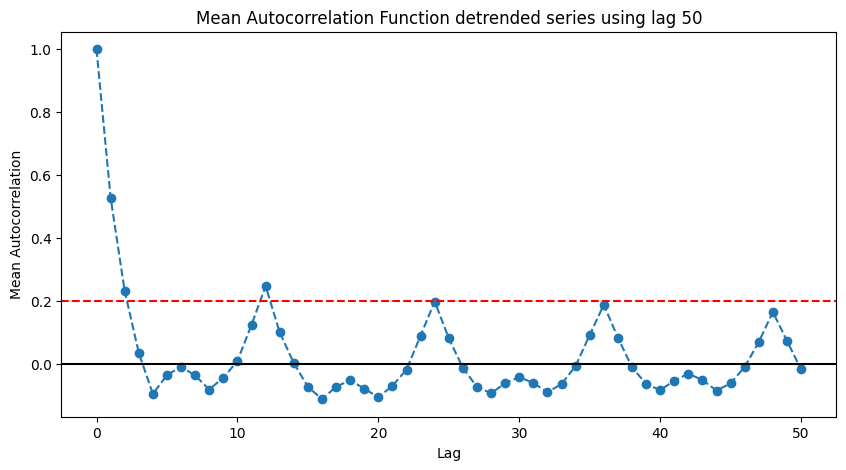

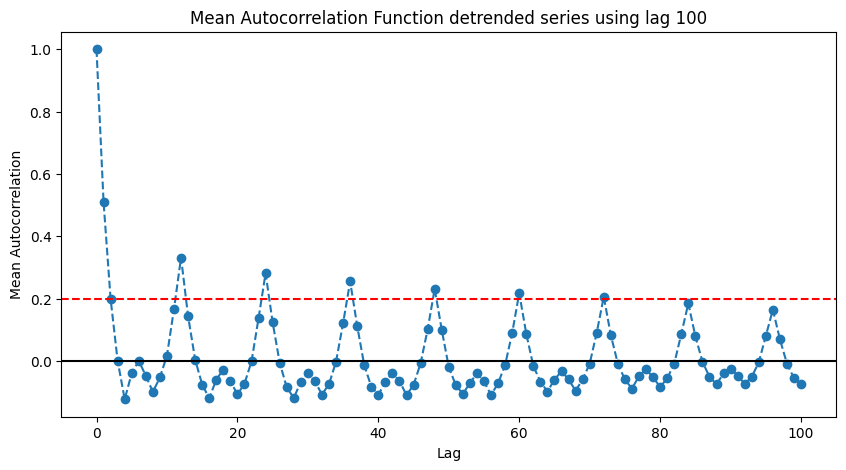

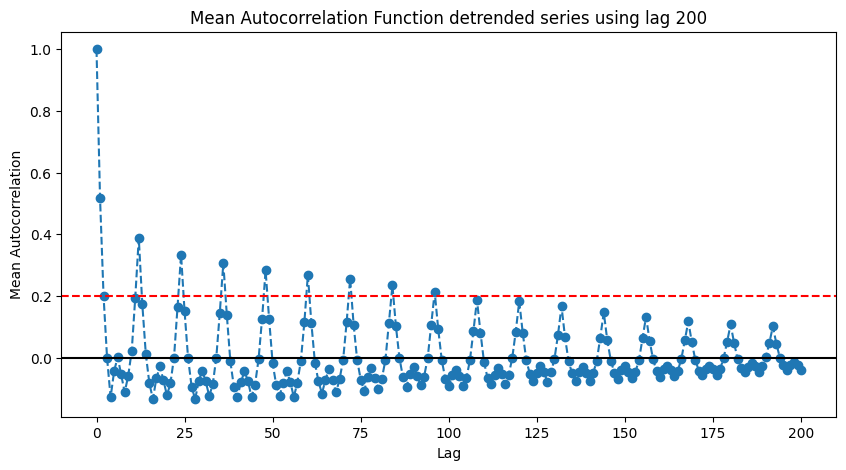

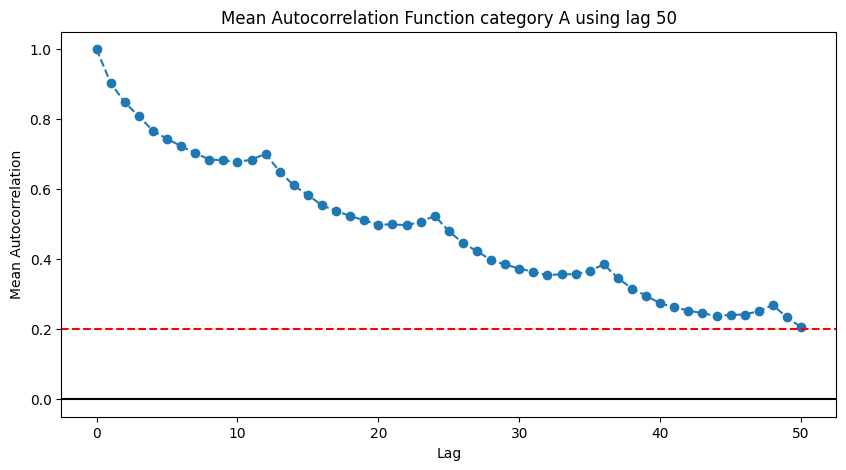

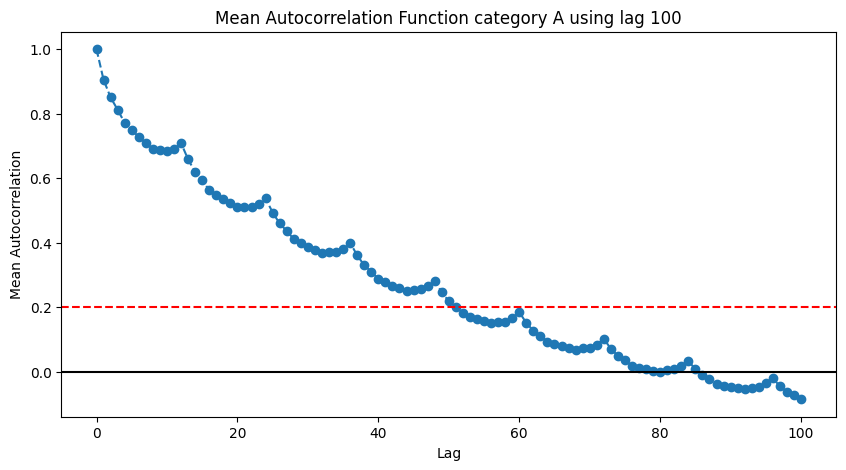

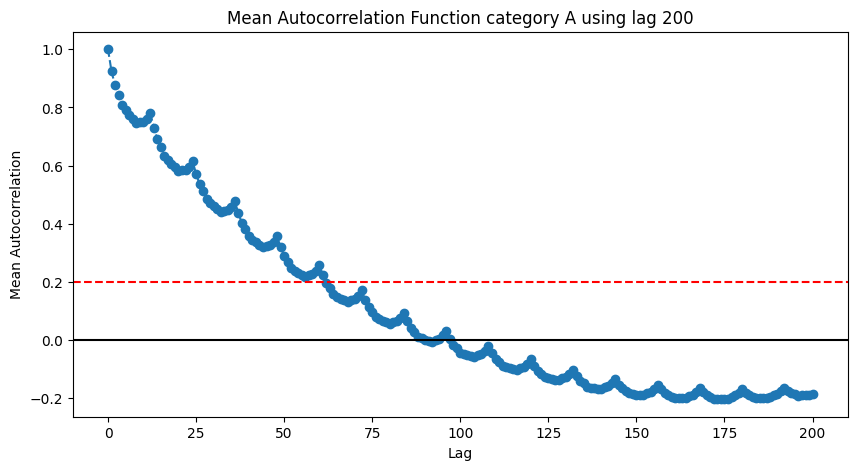

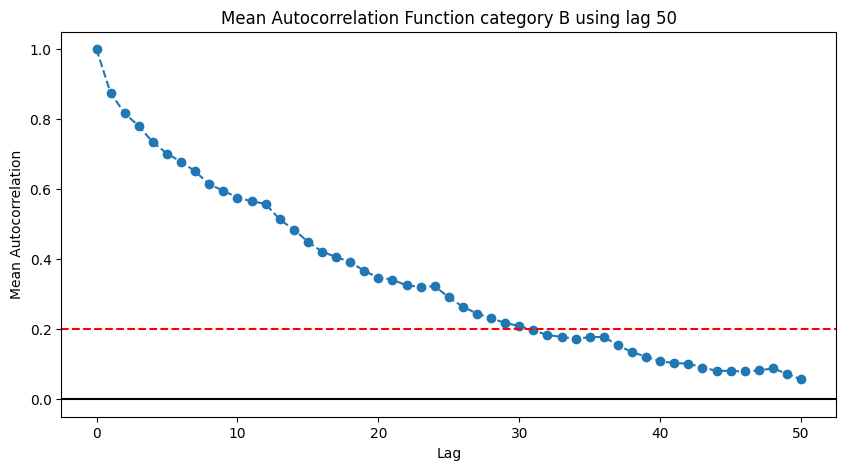

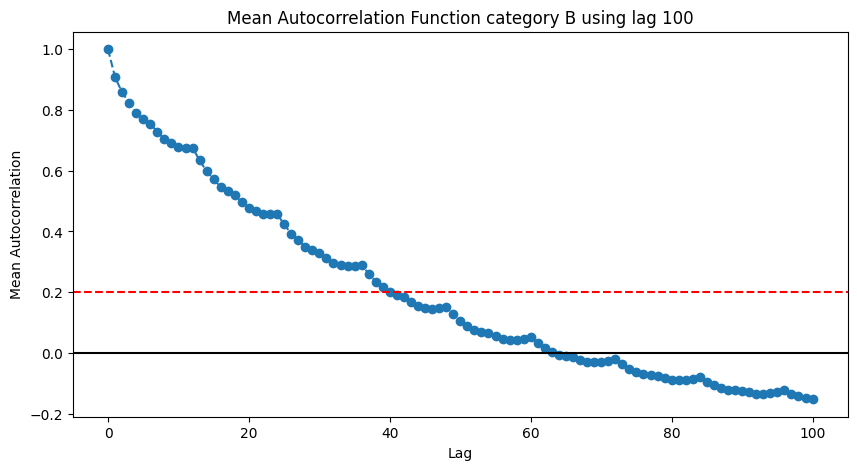

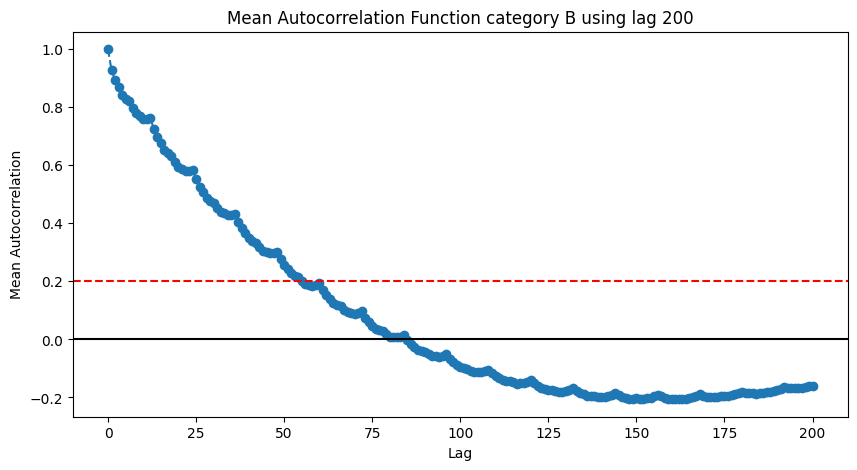

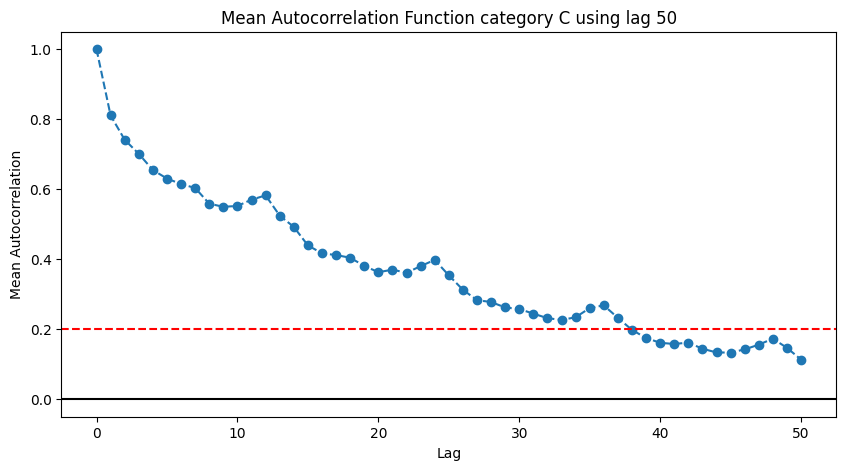

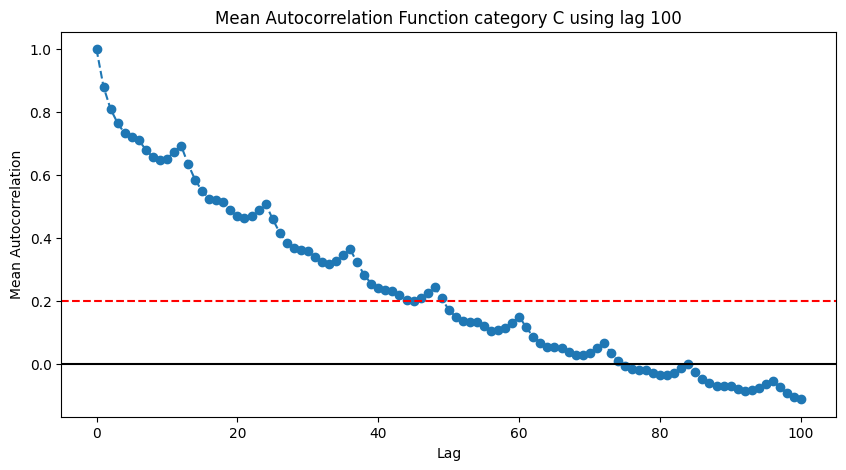

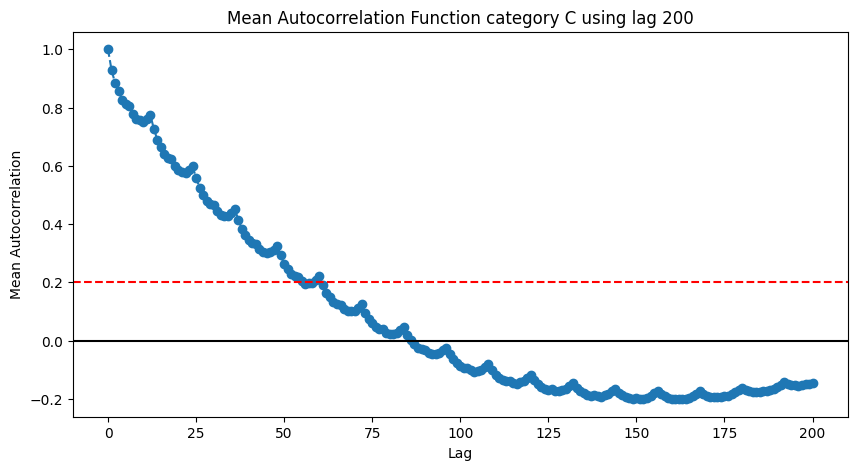

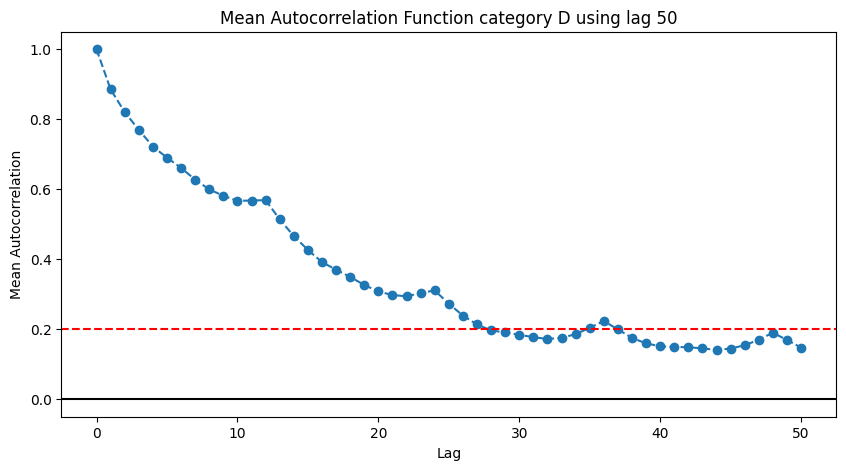

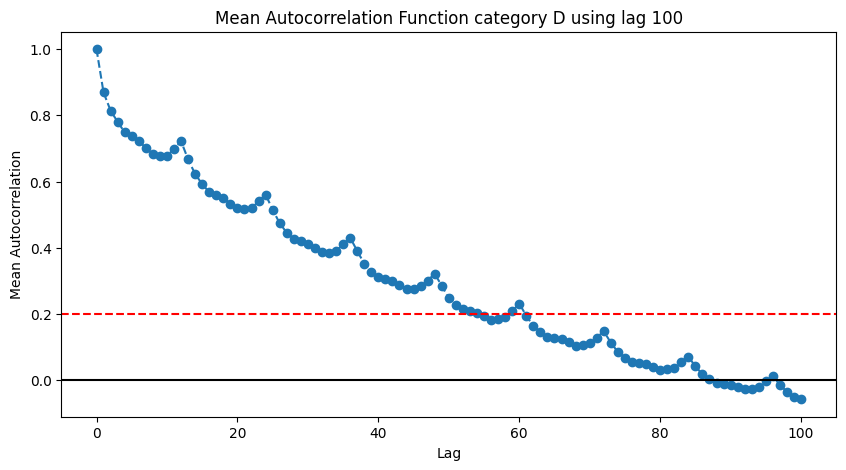

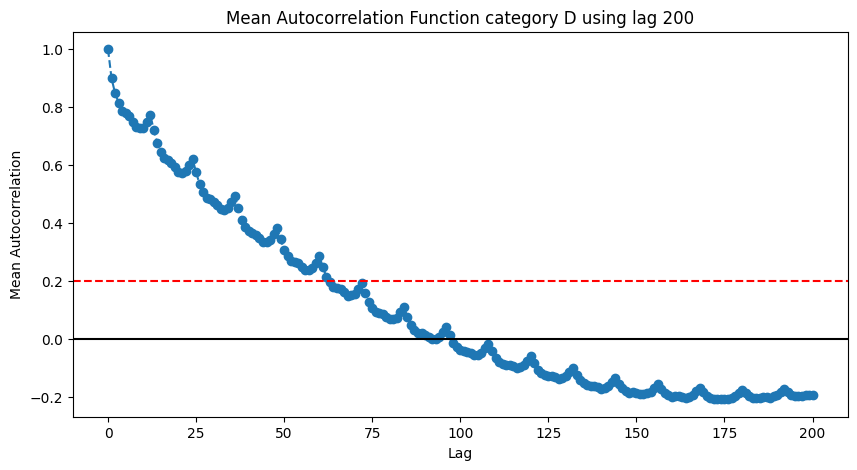

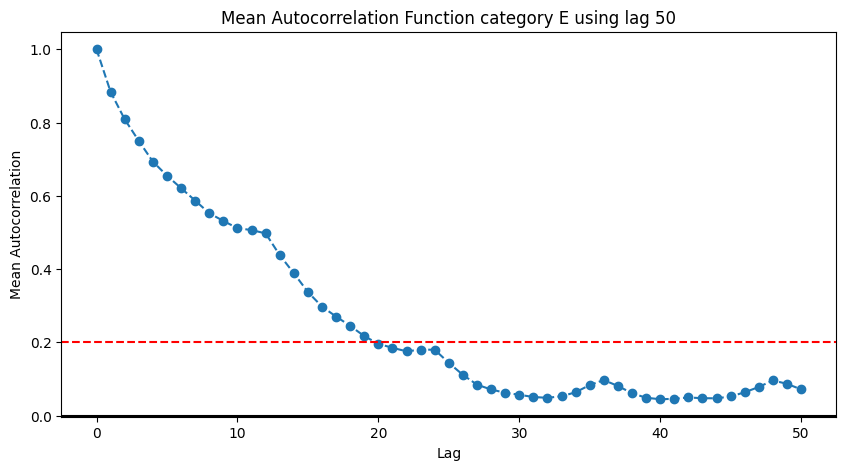

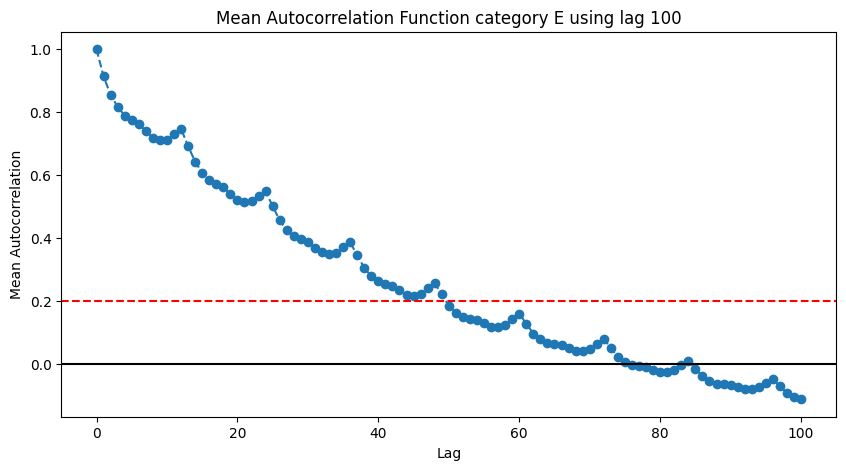

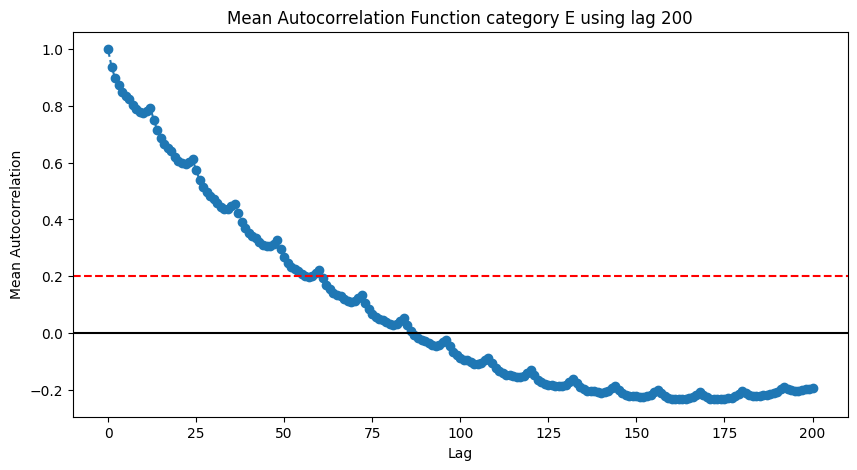

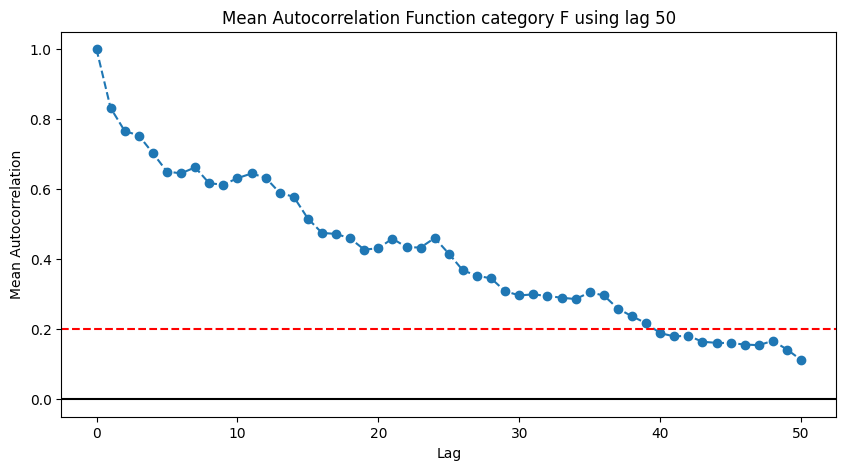

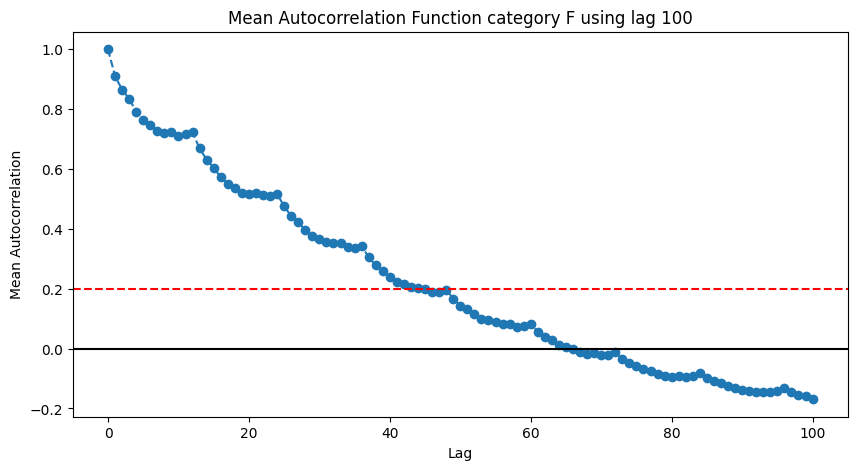

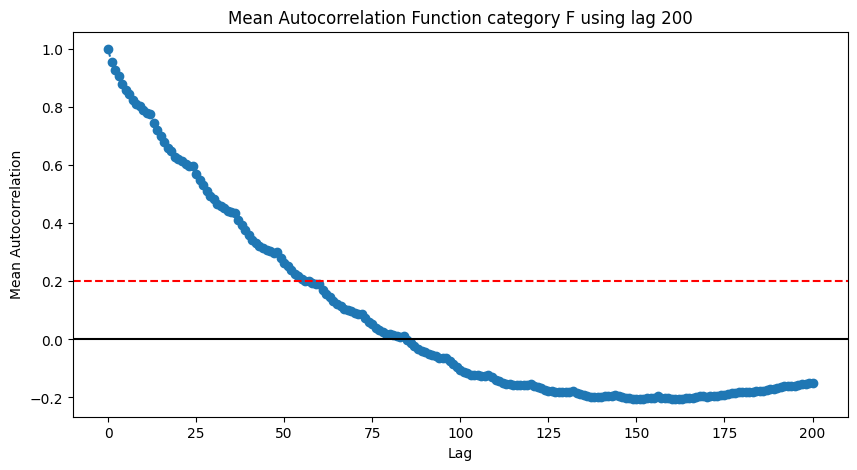

In [ ]:
autocorrelation_with_detrended_series = True                                    # Flag that says if we want to plot the mean autocorrelation function for all the detrended series
autocorrelation_with_original_series_per_category = True                        # Flag that says if we want to plot the mean autocorrelation function for all the original series in each single category
lags = [50, 100, 200]                                                           # Lag values to use

if autocorrelation_with_detrended_series:
    for lag in lags:
        plot_mean_acf(detrended_series, lag, f'Mean Autocorrelation Function detrended series using lag {lag}')

if autocorrelation_with_original_series_per_category:
    for category_label in sorted(list(series_per_category.keys())):
        for lag in lags:
            plot_mean_acf(series_per_category[category_label], lag, f'Mean Autocorrelation Function category {category_label} using lag {lag}')

Computing the stationary series

In [ ]:
for series in detrended_series:

    act_series = acf(series, nlags=len(series), fft=True)                       # Computing the autocorrelation function of each detrended series

    # To find the periodicity of each series we want to find the first spike in the autocorrelation function of the detrended version of the series
    # To avoid misrecognizing the first spike we need to eliminate the first values of the autocorrelation function output because they are certainly very high (see previous plots)
    # For example, the first value is always equal to 1
    for i in range(0, 7):
        act_series[i] = -2

    seasonality_index = np.argmax(act_series)                                   # Computing the periodicity

    stationary_series = []

    for i in range(0, seasonality_index):                                       # Padding the stationary series with zeros
        stationary_series.append(0)

    # We then use the technique of differencing to remove the seasonal component from the detrended series by subtracting from it a lagged version of itself
    for i in range(seasonality_index, len(series)):
        stationary_series.append(series[i] - series[i - seasonality_index])

    seasonality_index_of_series.append(seasonality_index)
    all_stationary_series.append(stationary_series)

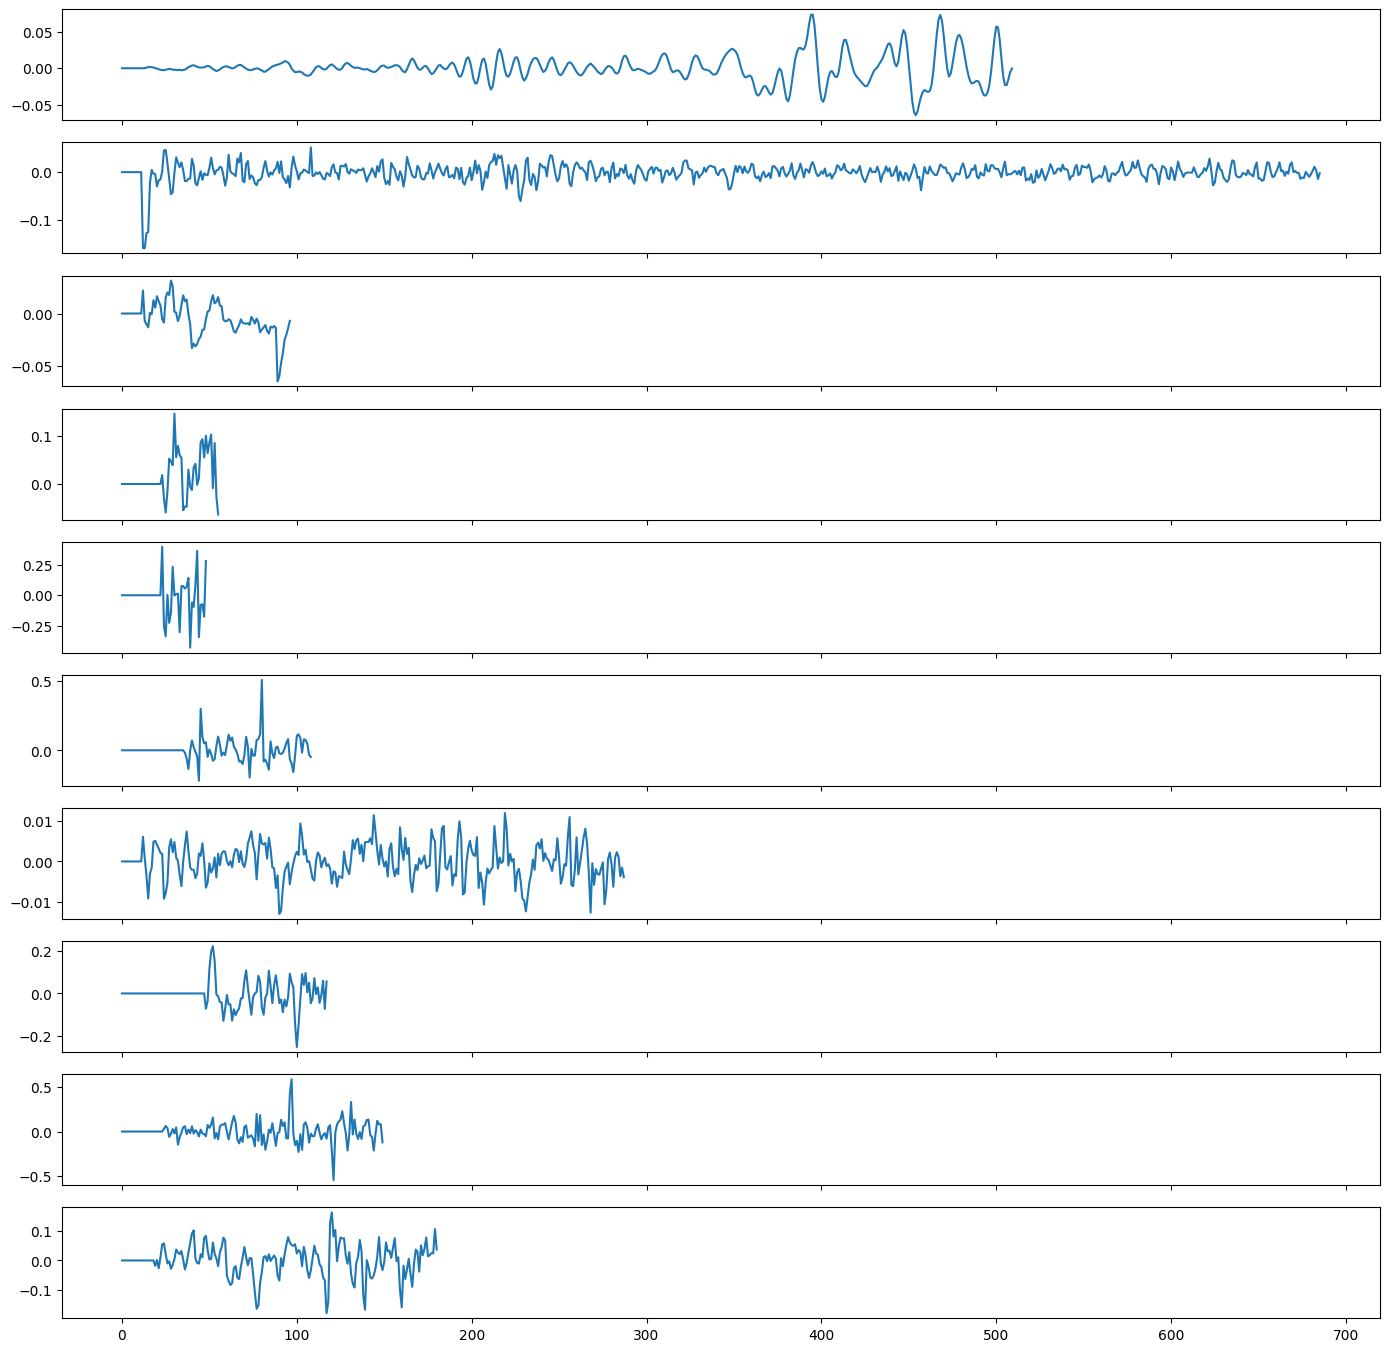

In [ ]:
# Plot some stationary series
inspect_dataframe(all_stationary_series, 10)

Split stationary series in train, validation and, possibly, test set (90% for training, 10% for validation and 0% for testing)

In [ ]:
# Split stationary time series in train, validation and test set

save_npy_stationary_files = True                                                # Flag that says if the training, the validation and, possibly, the test set should be saved on file
use_stationary_test = False                                                     # Flag that says if the test set is needed

percentage_of_train = 0.9
percentage_of_validation = 0.1

# For each set we consider the original series, the rolling mean series, the detrended series, the periodicity, the stationary series
# because they are all necessary information to do the reverse process from stationary series to original series
labels = {'originalSeries': 0, 'rollingMeanSeries': 1, 'detrendSeries': 2, 'seasonalityIndexOfSeries': 3, 'stationaritySeries': 4}

train_data = [list(), list(), list(), list(), list()]
validation_data = [list(), list(), list(), list(), list()]
test_data = [list(), list(), list(), list(), list()]

full_info_train_file_path = "./tmp/fullTrainData.npy"
full_info_validation_file_path = "./tmp/fullValidationData.npy"
full_info_test_file_path = "./tmp/fullTestData.npy"

tr,vl,ts = split_datasets(original_series, percentage_of_train, percentage_of_validation, use_stationary_test)
train_data[labels['originalSeries']] = tr
validation_data[labels['originalSeries']] = vl
test_data[labels['originalSeries']] = ts

tr,vl,ts = split_datasets(rolling_mean_series, percentage_of_train, percentage_of_validation, use_stationary_test)
train_data[labels['rollingMeanSeries']] = tr
validation_data[labels['rollingMeanSeries']] = vl
test_data[labels['rollingMeanSeries']] = ts

tr,vl,ts = split_datasets(detrended_series, percentage_of_train, percentage_of_validation, use_stationary_test)
train_data[labels['detrendSeries']] = tr
validation_data[labels['detrendSeries']] = vl
test_data[labels['detrendSeries']] = ts

tr,vl,ts = split_datasets(seasonality_index_of_series, percentage_of_train, percentage_of_validation, use_stationary_test)
train_data[labels['seasonalityIndexOfSeries']] = tr
validation_data[labels['seasonalityIndexOfSeries']] = vl
test_data[labels['seasonalityIndexOfSeries']] = ts

tr,vl,ts = split_datasets(all_stationary_series, percentage_of_train, percentage_of_validation, use_stationary_test)
train_data[labels['stationaritySeries']] = tr
validation_data[labels['stationaritySeries']] = vl
test_data[labels['stationaritySeries']] = ts

if save_npy_stationary_files:
  np.save(full_info_train_file_path, np.array(train_data))
  np.save(full_info_validation_file_path, np.array(validation_data))

  if use_stationary_test:
    np.save(full_info_test_file_path, np.array(test_data))